# Ridge Regression Benchmark
Train a regularized linear baseline aligned with the Gold dataset and shared configuration. This model emphasises interpretability and produces prediction intervals for downstream analysis notebooks.

In [ ]:
import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

project_root = Path.cwd().parents[1]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from config import (
    DATA_DIR_GOLD,
    LISTINGS_GOLD,
    RESULTS_DIR,
    MODEL_CONFIG,
    NUMERIC_FEATURES,
    CATEGORICAL_FEATURES,
    TARGET_VARIABLE
)
from elferspot_listings.utils.helpers import load_data, ensure_dir, setup_logging

logger = setup_logging(level='INFO')
RANDOM_SEED = MODEL_CONFIG['random_state']
RESULTS_MODEL_DIR = ensure_dir(RESULTS_DIR / 'model_predictions')
RUN_ID = datetime.utcnow().strftime('%Y%m%d_%H%M%S')

In [ ]:
gold_files = sorted(DATA_DIR_GOLD.glob('listings_gold*.xlsx'))
gold_path = gold_files[-1] if gold_files else LISTINGS_GOLD
if not gold_path.exists():
    raise FileNotFoundError(f"Gold dataset missing at {gold_path}")

df_gold = load_data(gold_path)
print(f"Loaded {len(df_gold):,} rows from {gold_path.name}")
df_gold.head()

## Load Gold data
Select the freshest Gold-layer extract so the baseline stays aligned with the CatBoost training set.

In [ ]:
numeric_features = [col for col in NUMERIC_FEATURES if col in df_gold.columns]
categorical_features = [col for col in CATEGORICAL_FEATURES if col in df_gold.columns]
required_columns = numeric_features + categorical_features + [TARGET_VARIABLE]

missing_columns = [col for col in required_columns if col not in df_gold.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

df_model = df_gold[required_columns].dropna(subset=[TARGET_VARIABLE]).copy()

for col in categorical_features:
    df_model[col] = df_model[col].fillna('Unknown').astype(str)

for col in numeric_features:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
    df_model[col] = df_model[col].fillna(df_model[col].median())

print(f"Modeling dataset shape: {df_model.shape}")
print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

## Prepare features
Use the shared configuration so Ridge aligns with CatBoost and downstream analysis expectations.

In [ ]:
X = df_model[numeric_features + categorical_features]
y_log = np.log(np.maximum(df_model[TARGET_VARIABLE], 1))
price_series = df_model[TARGET_VARIABLE]

X_train, X_test, y_train, y_test, price_train, price_test = train_test_split(
    X,
    y_log,
    price_series,
    test_size=MODEL_CONFIG['test_size'],
    random_state=RANDOM_SEED
)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop',
)

alphas = MODEL_CONFIG['ridge']['alphas']
ridge_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RidgeCV(alphas=alphas, cv=MODEL_CONFIG['ridge']['cv']))
])

ridge_pipeline.fit(X_train, y_train)
best_alpha = ridge_pipeline.named_steps['model'].alpha_
print(f"Best alpha: {best_alpha}")

In [ ]:
y_train_pred_log = ridge_pipeline.predict(X_train)
y_test_pred_log = ridge_pipeline.predict(X_test)
y_train_pred_price = np.exp(y_train_pred_log)
y_test_pred_price = np.exp(y_test_pred_log)

def summarize_metrics(y_true, y_pred, label: str) -> dict:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{label} Metrics:")
    print(f"  RMSE: {rmse:,.4f}")
    print(f"  MAE:  {mae:,.4f}")
    print(f"  R²:   {r2:.4f}")
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

train_metrics_log = summarize_metrics(y_train, y_train_pred_log, 'Training (log)')
test_metrics_log = summarize_metrics(y_test, y_test_pred_log, 'Test (log)')
train_metrics_price = summarize_metrics(price_train, y_train_pred_price, 'Training (price)')
test_metrics_price = summarize_metrics(price_test, y_test_pred_price, 'Test (price)')

residuals_price = price_test - y_test_pred_price
residuals_log = y_test - y_test_pred_log
ci_z = 1.645
residual_std_log = residuals_log.std(ddof=1)
pred_lower = np.exp(y_test_pred_log - ci_z * residual_std_log)
pred_upper = np.exp(y_test_pred_log + ci_z * residual_std_log)

print(f"\nTest R² gap (price): {train_metrics_price['R2'] - test_metrics_price['R2']:.4f}")

✅ Exported all results and underpriced listings (ridge regression) to listings_ridge_regression_results.xlsx
Best alpha (ridge): 1.0
Test R² (ridge, log-space): 0.7566


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(price_test, y_test_pred_price, alpha=0.5)
axes[0].plot([price_test.min(), price_test.max()], [price_test.min(), price_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price (EUR)')
axes[0].set_ylabel('Predicted Price (EUR)')
axes[0].set_title(f'Predicted vs Actual\nR²={test_metrics_price["R2"]:.3f}')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test_pred_price, residuals_price, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Price (EUR)')
axes[1].set_ylabel('Residuals (EUR)')
axes[1].set_title('Residual Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

sns.histplot(residuals_price, bins=40, kde=True)
plt.title('Residual Distribution (EUR)')
plt.xlabel('Residual')
plt.show()

Test R² (ridge, log-space, no outliers): 0.7587
Best alpha (ridge, no outliers): 1.0


## Persist predictions
Save Ridge prediction intervals for analysis notebooks and regression diagnostics.

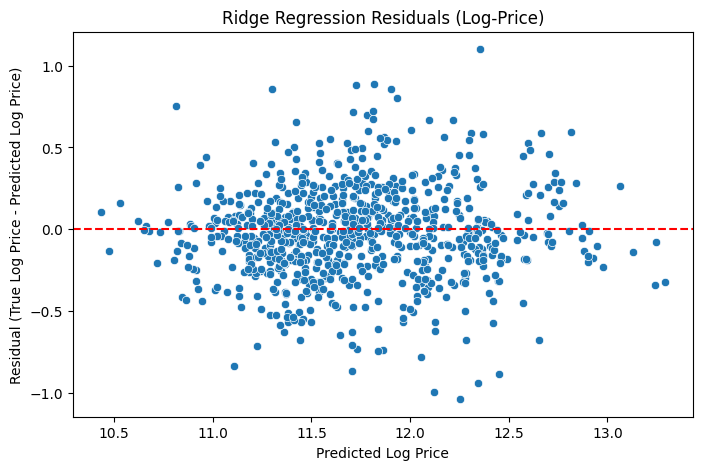

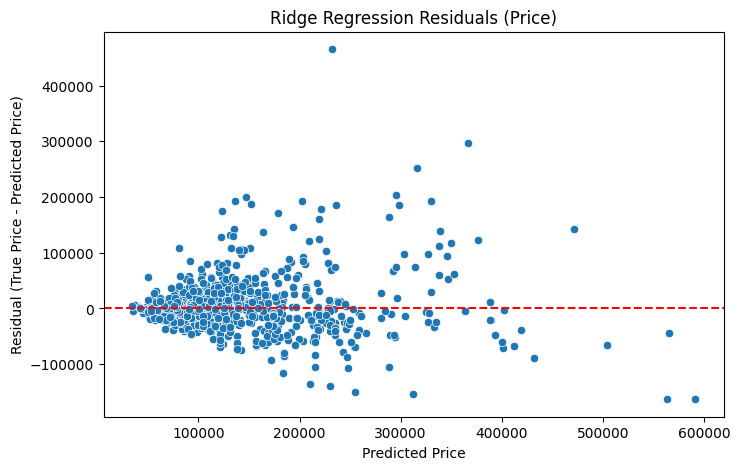

In [ ]:
base_cols = [
    'URL',
    'Title',
    'Model',
    'Series',
    'Year of construction',
    'Mileage_km',
    'price_in_eur',
    'Car location',
]
available_cols = [col for col in base_cols if col in df_gold.columns]
results_df = df_gold.loc[X_test.index, available_cols].copy()
results_df['pred_price'] = y_test_pred_price
results_df['pred_lower'] = pred_lower
results_df['pred_upper'] = pred_upper
results_df['residual_price'] = residuals_price
results_df['residual_log'] = residuals_log
results_df['model'] = 'ridge'
results_df['run_id'] = RUN_ID

underpriced_df = results_df[results_df['price_in_eur'] < results_df['pred_lower']]
overpriced_df = results_df[results_df['price_in_eur'] > results_df['pred_upper']]

prediction_file_ridge = RESULTS_MODEL_DIR / f"ridge_predictions_{RUN_ID}.xlsx"
with pd.ExcelWriter(prediction_file_ridge) as writer:
    results_df.sort_values('residual_price').to_excel(writer, sheet_name='all_results', index=False)
    underpriced_df.sort_values('residual_price').to_excel(writer, sheet_name='underpriced', index=False)
    overpriced_df.sort_values('residual_price').to_excel(writer, sheet_name='overpriced', index=False)

print(f"✓ Ridge predictions saved to {prediction_file_ridge}")
print(f"  Underpriced candidates: {len(underpriced_df)}")
print(f"  Overpriced candidates: {len(overpriced_df)}")

## Summary
- **Test R²:** {test_metrics_price['R2']:.4f} | **RMSE:** {test_metrics_price['RMSE']:,.2f} EUR | **MAE:** {test_metrics_price['MAE']:,.2f} EUR
- **Best alpha:** {best_alpha} across {len(alphas)} candidates
- **Predictions file:** `{prediction_file_ridge.name}` written to `results/model_predictions/`
- Feed the exported predictions to notebooks in `05_analysis/` for pricing insights.